# Multiple Results Analysis

This notebook is intended to read a simulation results file with multiple simulations and results and create aggregate analyses and visualizations.

**Goal**:

1. Raft doesn't commit forks 
2. Raft accepts first seen 
3. Eventual chooses raft then latest

**Experimental control variables:**

- _increasing WAN latency, e.g. T (tick)_
- increasing number of nodes
- increasing amounts of failure

**Metrics:**

- number of forks
- number of stale reads
- percent visible (for full replication)
- percent committed
- number of messages
- read latency
- write latency
- visibility latency
- commit latency

In [1]:
%matplotlib inline

import os
import sys 
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import graph_tool.all as gt
import matplotlib.pyplot as plt

from operator import itemgetter
from itertools import groupby, chain
from collections import defaultdict, Counter

# Modify the Notebook path
sys.path.append(os.path.join(os.getcwd(), ".."))

from cloudscope.colors import ColorMap
from cloudscope.results import Results
from cloudscope.results.graph import extract_graph
from cloudscope.results.analysis import create_per_replica_dataframe as create_replica_dataframe
from cloudscope.results.analysis import create_per_experiment_dataframe as create_dataframe
from cloudscope.results.analysis import results_values as rvals

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [42]:
sns.set_style('whitegrid')
sns.set_context('notebook')

In [24]:
# Specify a path to a results file 
# If None, will attempt to look one up
FIXTURES = os.path.join("..", "fixtures", "results")
FIGURES  = "/Users/benjamin/Desktop/Results/"
# RESULTS  = os.path.join(FIXTURES, "federated-multi-original-1user-bailis.json")
# RESULTS  = os.path.join(FIXTURES, "federated-multi-original-1user-howard.json")
RESULTS  = os.path.join(FIXTURES, "federated-multi-realism-bailis.json")


def get_results_data(path=RESULTS):
    with open(path, 'r') as f:
        data = json.load(f)
    
    for result in data:
        yield Results(**result)

# Load the data
results = list(get_results_data())

In [4]:
# Print report details 
def report_settings(exclude=None):
    table = defaultdict(dict)
    exclude = exclude or frozenset([
        'valid_locations', 'invalid_types', 
        'default_replica', 'default_consistency', 'default_latency', 
        'max_sim_time', 'title', 'description',
        'election_timeout', 'heartbeat_interval',
    ])
    
    for idx, conf in enumerate(rvals(results, 'settings')):
        eid = "e{:0>2}".format(idx)
        table[eid]['name'] = eid
        for key, val in conf.iteritems():
            if key in exclude: continue
            table[eid][key] = val
    
    for idx, conf in enumerate(rvals(results, 'topology', 'meta')):
        eid = "e{:0>2}".format(idx)
        for key, val in conf.iteritems():
            if key in exclude: continue
            table[eid][key] = val

    return pd.DataFrame(table.values())

settings = report_settings()

In [5]:
df = create_dataframe(results)
df = df.fillna(0)

In [6]:
print("\n".join(df.columns))

T parameter model
anti-entropy delay (ms)
committed writes
completed reads
completed writes
dropped writes
eid
election timeout (ms, ms)
empty reads
forked writes
heartbeat interval (ms)
latency range (ms)
mean commit latency (ms)
mean dropped write latency (ms)
mean latency (ms)
mean message latency (ms)
mean read latency (ms)
mean visibility latency (ms)
mean write latency (ms)
message types
reads
recv
sent
stale reads
standard deviation of latency (ms)
tick metric (T)
type
unforked writes
users
visible writes
writes
inconsistent writes


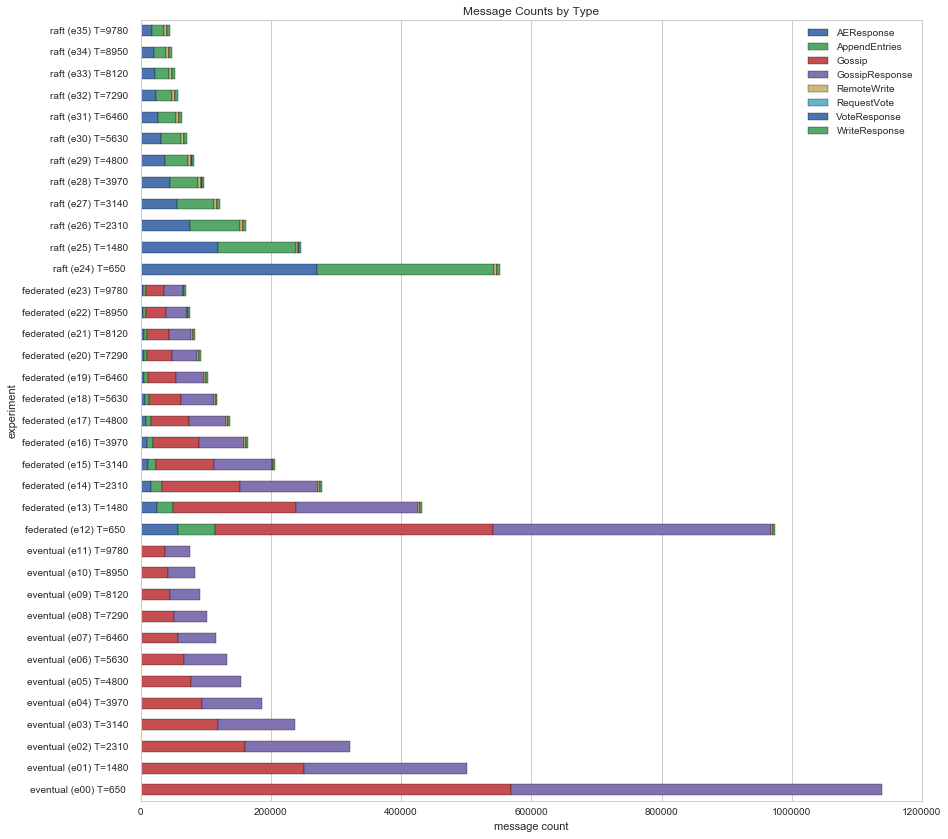

In [45]:
def get_message_rows(df):
    for row in df[['message types', 'tick metric (T)', 'type', 'eid']].itertuples(): 
        item = row[1]
        item['experiment'] = "{} ({}) T={: <6}".format(row[3], row[4], row[2])
        yield item

# Create the data frame 
msgs = pd.DataFrame(get_message_rows(df))

# Create the figure 
fig = plt.figure(figsize=(14,14))
ax  = fig.add_subplot(111)
mpl.rcParams.update({'font.size': 22})

# Plot the bar chart 
g = msgs.plot(
    x='experiment', kind='barh', stacked=True, ax=ax, 
    title="Message Counts by Type", color=sns.color_palette()
)

# Modify the figure 
ax.set_xlabel("message count")
ax.yaxis.grid(False)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'message_counts.png'))

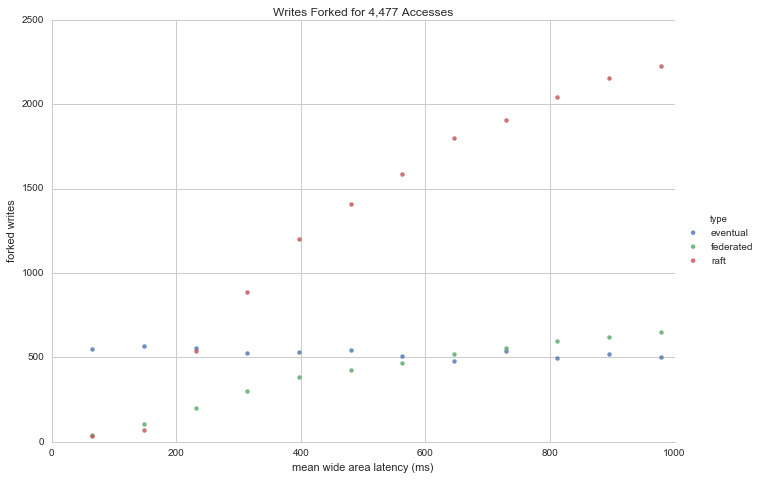

In [46]:
# Forked Writes (two keys: "inconsistent writes" and "forked writes")
g = sns.lmplot(
    x="mean latency (ms)", y="forked writes", hue='type', 
    data=df, fit_reg=False, size=7, aspect=1.4
)

# Set the title and the labels 
g.ax.set_title("Writes Forked for {:,} Accesses".format(df.writes.max()))
g.ax.set_xlabel("mean wide area latency (ms)")

# Modify the axis limits  
g.ax.set_ylim(0, 2500)
g.ax.set_xlim(0, 1000)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'forked_writes.png'))

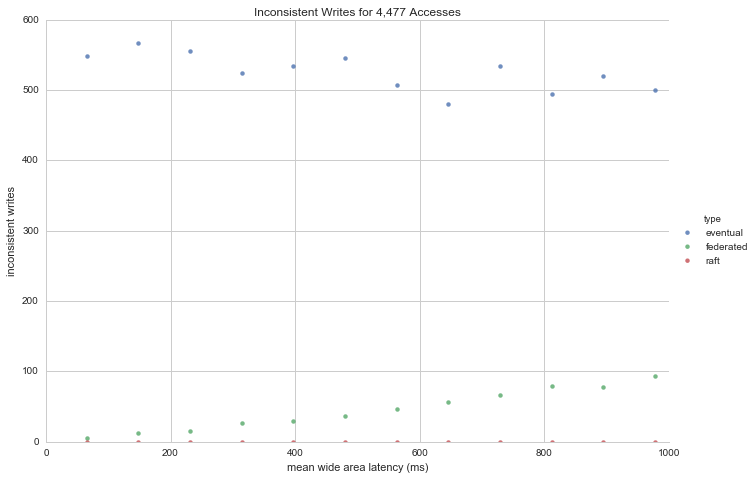

In [47]:
# Forked Writes (two keys: "inconsistent writes" and "forked writes")
g = sns.lmplot(
    x="mean latency (ms)", y="inconsistent writes", hue='type', 
    data=df, fit_reg=False, size=7, aspect=1.4
)

# Set the title and the labels 
g.ax.set_title("Inconsistent Writes for {:,} Accesses".format(df.writes.max()))
g.ax.set_xlabel("mean wide area latency (ms)")

# Modify the axis limits  
g.ax.set_ylim(0, 600)
g.ax.set_xlim(0, 1000)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'inconsistent_writes.png'))

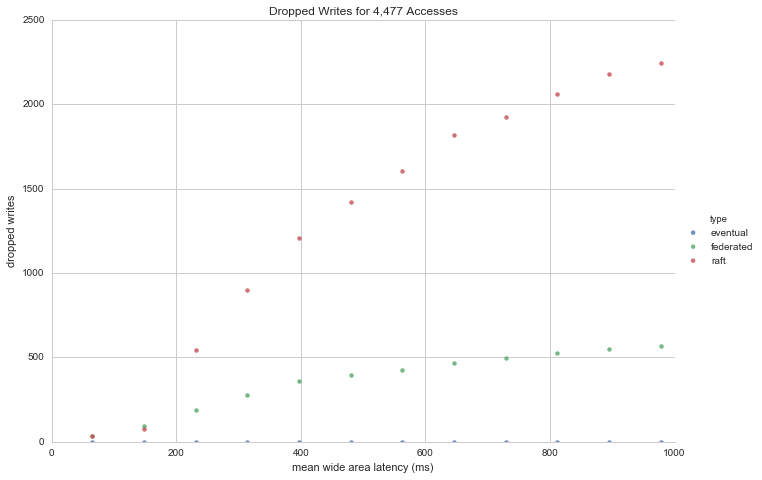

In [51]:
# Dropped Writes
g = sns.lmplot(
    x="mean latency (ms)", y="dropped writes", hue='type', 
    data=df, fit_reg=False, size=7, aspect=1.4
)

# Set the title and the labels 
g.ax.set_title("Dropped Writes for {:,} Accesses".format(df.writes.max()))
g.ax.set_xlabel("mean wide area latency (ms)")

# Modify the axis limits  
g.ax.set_ylim(0, 2500)
g.ax.set_xlim(0, 1000)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'dropped_writes.png'))

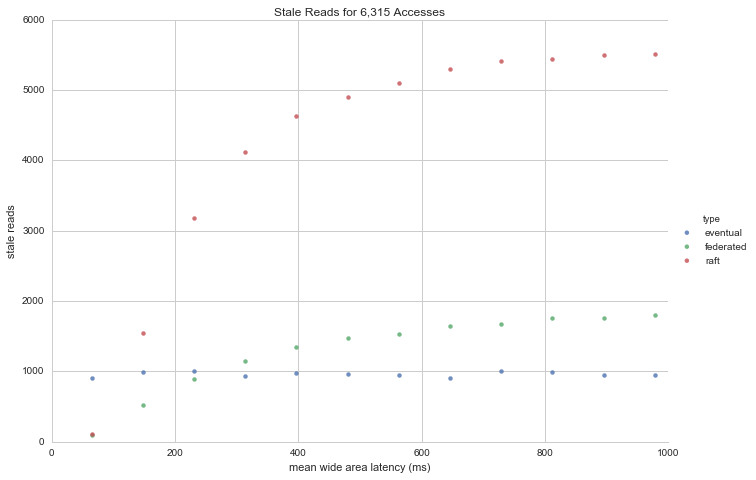

In [56]:
# Stale Reads
g = sns.lmplot(
    x="mean latency (ms)", y="stale reads", hue='type', 
    data=df, fit_reg=False, size=7, aspect=1.4
)

# Set the title and the labels 
g.ax.set_title("Stale Reads for {:,} Accesses".format(df.reads.max()))
g.ax.set_xlabel("mean wide area latency (ms)")

# Modify the axis limits  
g.ax.set_ylim(0, 6000)
g.ax.set_xlim(0, 1000)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'stale_reads.png'))

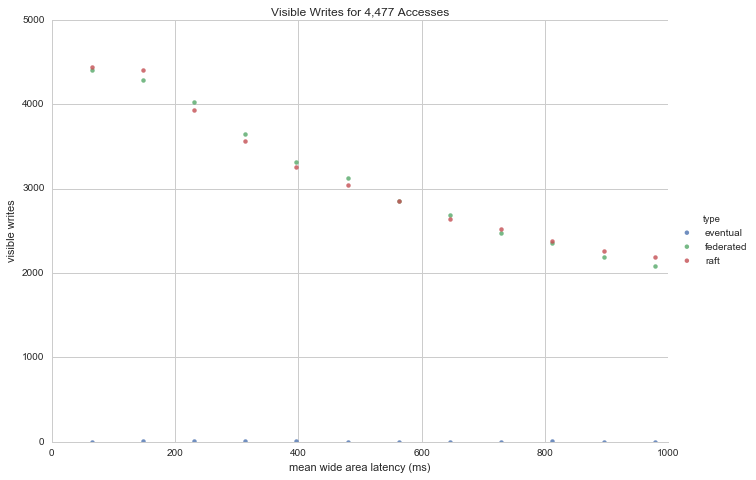

In [57]:
# Visible Writes
g = sns.lmplot(
    x="mean latency (ms)", y="visible writes", hue='type', 
    data=df, fit_reg=False, size=7, aspect=1.4
)

# Set the title and the labels 
g.ax.set_title("Visible Writes for {:,} Accesses".format(df.writes.max()))
g.ax.set_xlabel("mean wide area latency (ms)")

# Modify the axis limits  
g.ax.set_ylim(0, 5000)
g.ax.set_xlim(0, 1000)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'visible_writes.png'))

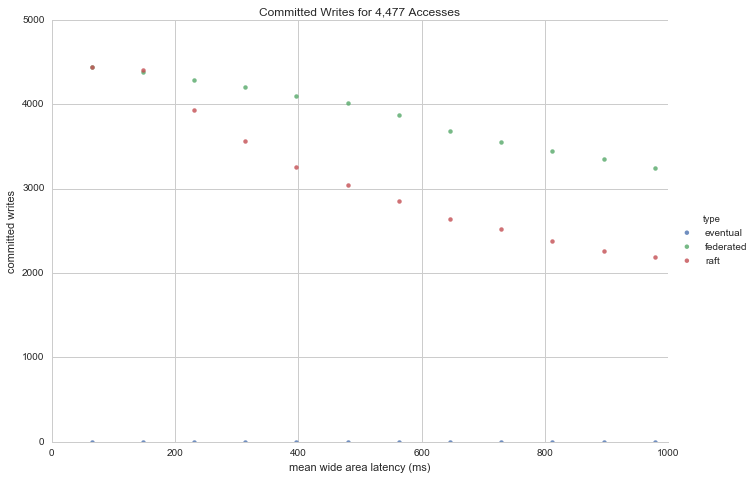

In [58]:
# Comitted Writes
g = sns.lmplot(
    x="mean latency (ms)", y="committed writes", hue='type', 
    data=df, fit_reg=False, size=7, aspect=1.4
)

# Set the title and the labels 
g.ax.set_title("Committed Writes for {:,} Accesses".format(df.writes.max()))
g.ax.set_xlabel("mean wide area latency (ms)")

# Modify the axis limits  
g.ax.set_ylim(0, 5000)
g.ax.set_xlim(0, 1000)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'committed_writes.png'))

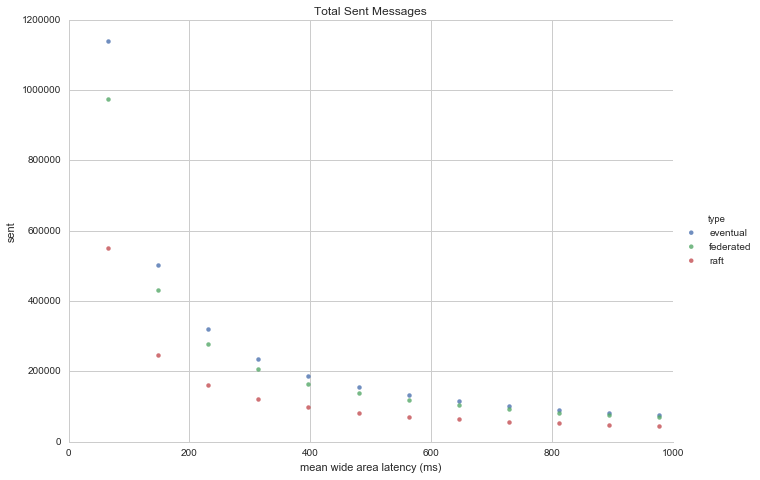

In [59]:
# Number of Messages 
g = sns.lmplot(
    x="mean latency (ms)", y="sent", hue='type', 
    data=df, fit_reg=False, size=7, aspect=1.4
)

# Set the title and the labels 
g.ax.set_title("Total Sent Messages")
g.ax.set_xlabel("mean wide area latency (ms)")

# Modify the axis limits  
g.ax.set_ylim(0, 1200000)
g.ax.set_xlim(0, 1000)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'messages_sent.png'))

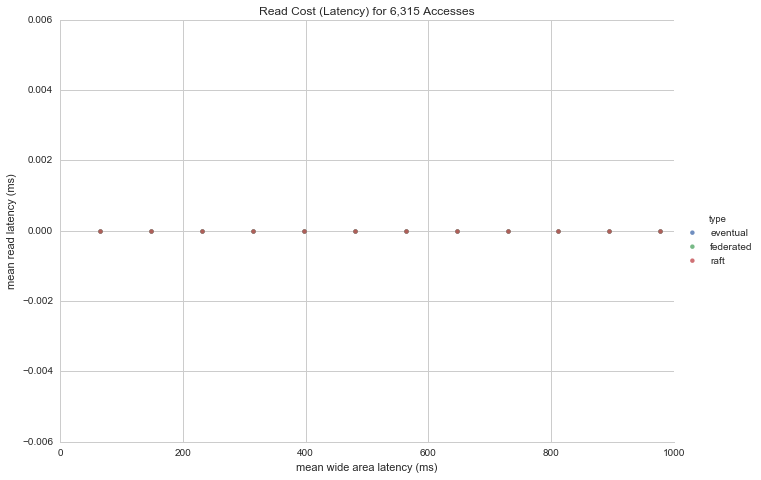

In [60]:
# Read cost (ms delay before read)
g = sns.lmplot(
    x="mean latency (ms)", y="mean read latency (ms)", hue='type', 
    data=df, fit_reg=False, size=7, aspect=1.4,
)

# Set the title and the labels 
g.ax.set_title("Read Cost (Latency) for {:,} Accesses".format(df.reads.max()))
g.ax.set_xlabel("mean wide area latency (ms)")

# Modify the axis limits  
g.ax.set_xlim(0, 1000)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'read_latency.png'))

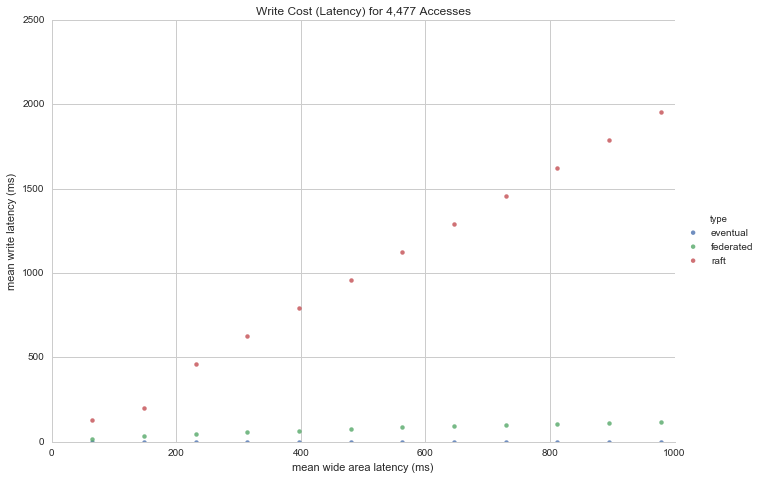

In [61]:
# Write Cost (ms delay before write)
g = sns.lmplot(
    x="mean latency (ms)", y="mean write latency (ms)", hue='type', 
    data=df, fit_reg=False, size=7, aspect=1.4,
)

# Set the title and the labels 
g.ax.set_title("Write Cost (Latency) for {:,} Accesses".format(df.writes.max()))
g.ax.set_xlabel("mean wide area latency (ms)")

# Modify the axis limits  
g.ax.set_ylim(0, 2500)
g.ax.set_xlim(0, 1000)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'write_latency.png'))

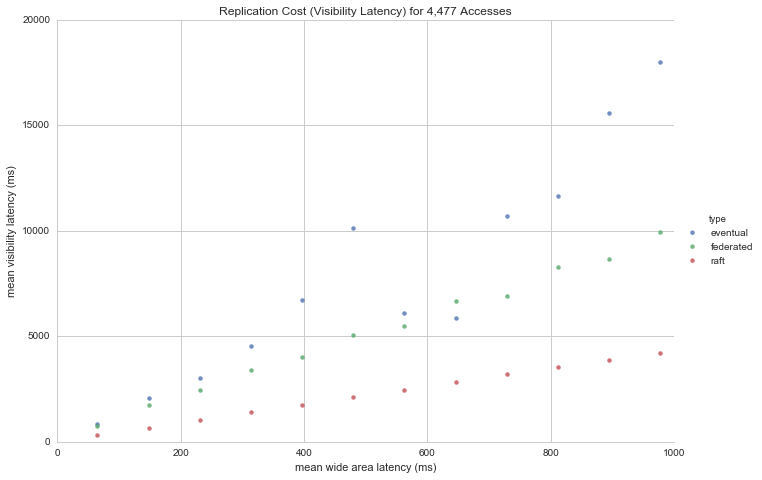

In [62]:
# Replication Cost (Visibility Latency)
g = sns.lmplot(
    x="mean latency (ms)", y="mean visibility latency (ms)", hue='type', 
    data=df, fit_reg=False, size=7, aspect=1.4
)

# Set the title and the labels 
g.ax.set_title("Replication Cost (Visibility Latency) for {:,} Accesses".format(df.writes.max()))
g.ax.set_xlabel("mean wide area latency (ms)")

# Modify the axis limits  
g.ax.set_ylim(0, 20000)
g.ax.set_xlim(0, 1000)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'visibility_latency.png'))

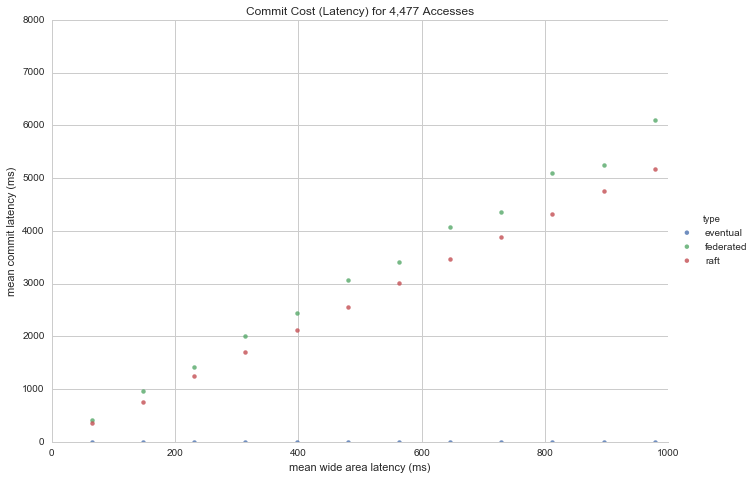

In [63]:
# Commit Cost (Commit Latency)
g = sns.lmplot(
    x="mean latency (ms)", y="mean commit latency (ms)", hue='type', 
    data=df, fit_reg=False, size=7, aspect=1.4
)

# Set the title and the labels 
g.ax.set_title("Commit Cost (Latency) for {:,} Accesses".format(df.writes.max()))
g.ax.set_xlabel("mean wide area latency (ms)")

# Modify the axis limits  
g.ax.set_ylim(0, 8000)
g.ax.set_xlim(0, 1000)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'commit_latency.png'))

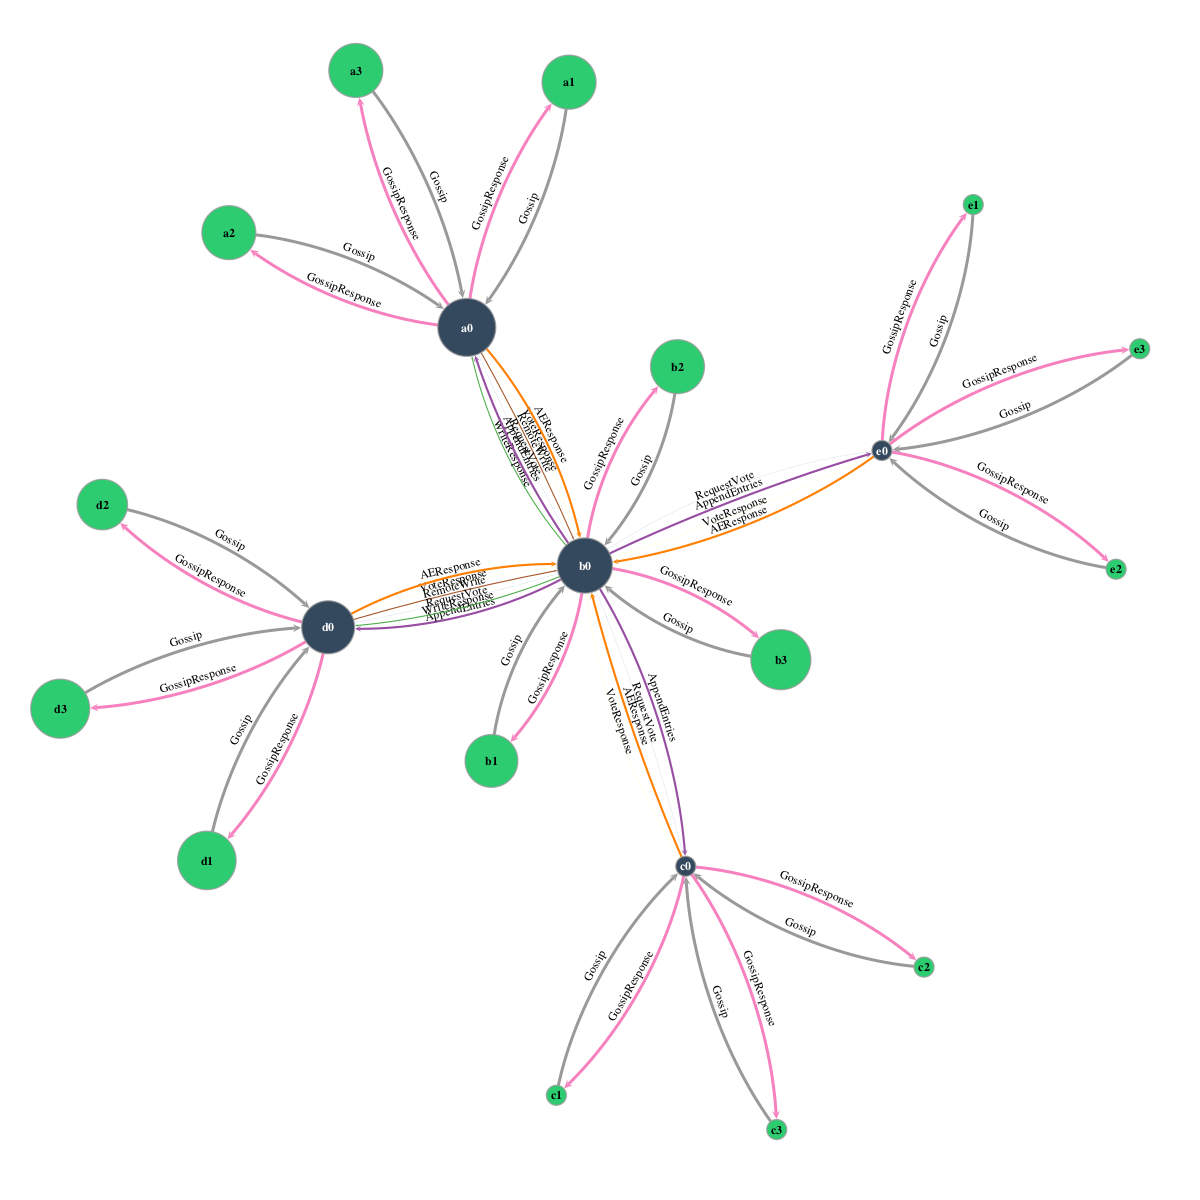

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x162a3b890, at 0x161c5ae10>

In [64]:
def find_results(etype='federated', tick=1480):
    for result in results:
        if result.settings['type'] == etype and result.settings['tick_metric'] == tick:
            name = "{}-T{}.png".format(etype, tick)
            return result, name
    return None, None 


# Find the desired results 
result, name = find_results('federated')
if result is None: raise ValueError("Could not find results!")

# Extract the Graph Tool graph     
G = extract_graph(result, by_message_type=True)

# Draw the graph 
vlabel  = G.vp['id']
vsize   = G.vp['writes']
vsize   = gt.prop_to_size(vsize, ma=60, mi=20)

# Set the vertex color 
vcolor  = G.new_vertex_property('string') 
vcmap   = ColorMap('flatui', shuffle=False)
for vertex in G.vertices():
    vcolor[vertex] = vcmap(G.vp['consistency'][vertex])

# Set the edge color 
ecolor  = G.new_edge_property('string')
ecmap   = ColorMap('set1', shuffle=False)
for edge in G.edges():
    ecolor[edge] = ecmap(G.ep['label'][edge])

elabel  = G.ep['label']
esize   = G.ep['norm']
esize   = gt.prop_to_size(esize, mi=.1, ma=3)
eweight = G.ep['weight']

gt.graph_draw(
    G, output_size=(1200,1200), output=os.path.join(FIGURES, name),
    vertex_text=vlabel, vertex_size=vsize, vertex_font_weight=1, 
    vertex_pen_width=1.3, vertex_fill_color=vcolor,
    edge_pen_width=esize, edge_color=ecolor, edge_text=elabel
)